In [ ]:
!pip install contractions

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
import pickle

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, LSTM, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from utilities import *

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.2);

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
root = '/content/drive/My Drive/surely_not_sarcasm_data/'

# get data

In [6]:
df = pd.read_csv(root+'data/train_balanced_smaller.csv')
df.head()

,label,comment,parent_comment
0,0,NC and NH.,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",deadass don't kill my buzz
4,0,I could use one of those tools.,Yep can confirm I saw the tool they use for th...


In [7]:
X = df['comment'].values
y = df['label'].values

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.05, random_state=42)

In [9]:
X_train.shape, X_val.shape, X_test.shape

((768187,), (202155,), (40431,))

In [10]:
data = pickle.load(open(root+'preprocessed_data_1503', 'rb'))

# tokenize

In [11]:
input_dim = 10000
tokenizer = Tokenizer(num_words=input_dim, filters='')
tokenizer.fit_on_texts(data['X_train'])

In [12]:
X_train_tok = tokenizer.texts_to_sequences(data['X_train'])
X_val_tok = tokenizer.texts_to_sequences(data['X_val'])
X_test_tok = tokenizer.texts_to_sequences(data['X_test'])

In [13]:
np.quantile([len(i) for i in X_train_tok], 0.9)

22.0

In [14]:
maxlen = 20

In [15]:
X_train_tok = pad_sequences(X_train_tok, padding='post', maxlen=maxlen)
X_val_tok = pad_sequences(X_val_tok, padding='post', maxlen=maxlen)
X_test_tok = pad_sequences(X_test_tok, padding='post', maxlen=maxlen)

# embedding matrix

In [16]:
vec_len = 100

In [17]:
wordemb = WordEmbeddings()
embedding_matrix = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer, root=root)

coverage: 0.9815


# CNN + biLSTM

## normal embeddings
ran: 19.03.2022

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen, mask_zero=True,
              weights=[embedding_matrix], trainable=True),
    Conv1D(32, 3, activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(3),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    Bidirectional(LSTM(20, recurrent_dropout=0.5)),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 518s 84ms/step - loss: 0.5603 - accuracy: 0.7081 - val_loss: 0.5396 - val_accuracy: 0.7247
Epoch 2/50
6002/6002 [==============================] - 494s 82ms/step - loss: 0.5240 - accuracy: 0.7376 - val_loss: 0.5316 - val_accuracy: 0.7308
Epoch 3/50
6002/6002 [==============================] - 491s 82ms/step - loss: 0.5034 - accuracy: 0.7522 - val_loss: 0.5311 - val_accuracy: 0.7312
Epoch 4/50
6002/6002 [==============================] - 483s 80ms/step - loss: 0.4832 - accuracy: 0.7666 - val_loss: 0.5398 - val_accuracy: 0.7296
Epoch 5/50
6002/6002 [==============================] - 486s 81ms/step - loss: 0.4628 - accuracy: 0.7802 - val_loss: 0.5527 - val_accuracy: 0.7261


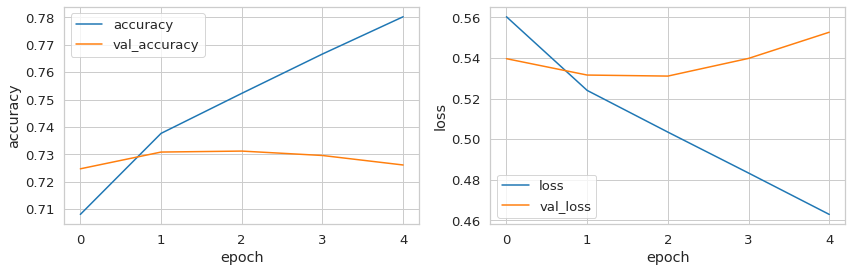

In [ ]:
plot_history(fit)

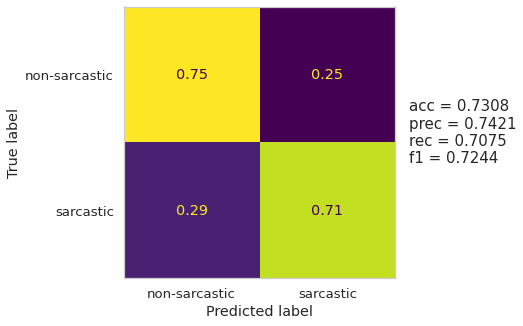

In [ ]:
evaluate(model, X_val_tok, y_val)

In [ ]:
show_errors(model, X_val, X_val_tok, y_val, n=5)

False negatives:
---------------------------
Haha his namw is MASTER CHEF
Have you tried acupuncture?
I blame noodles.
Pff, just another one of these Wenger Almost Signed Him scenarios... Starting to get ridiculous tbh.
coastguard?

False positives:
---------------------------
Maybe I shouldn't have thrown him at that monster that did 50 damage to me...
As a fan, so that there's easier access to it.
You can try the Richmond Olympic Oval
So terror
I just want to know she's comfortable!


In [ ]:
model.save(root+'cnn_bilstm_adam')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_bilstm_adam/assets


In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen, mask_zero=True, weights=[embedding_matrix],
              trainable=True, embeddings_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-5)),
    Conv1D(32, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling1D(3),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Bidirectional(LSTM(20, dropout=0.3)),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 97s 15ms/step - loss: 1.4988 - accuracy: 0.6975 - val_loss: 0.7073 - val_accuracy: 0.7087
Epoch 2/50
6002/6002 [==============================] - 86s 14ms/step - loss: 0.6587 - accuracy: 0.7177 - val_loss: 0.6343 - val_accuracy: 0.7187
Epoch 3/50
6002/6002 [==============================] - 87s 14ms/step - loss: 0.6207 - accuracy: 0.7249 - val_loss: 0.6195 - val_accuracy: 0.7221
Epoch 4/50
6002/6002 [==============================] - 91s 15ms/step - loss: 0.6075 - accuracy: 0.7292 - val_loss: 0.6058 - val_accuracy: 0.7286
Epoch 5/50
6002/6002 [==============================] - 88s 15ms/step - loss: 0.6024 - accuracy: 0.7323 - val_loss: 0.6019 - val_accuracy: 0.7299
Epoch 6/50
6002/6002 [==============================] - 86s 14ms/step - loss: 0.5989 - accuracy: 0.7351 - val_loss: 0.6000 - val_accuracy: 0.7333
Epoch 7/50
6002/6002 [==============================] - 86s 14ms/step - loss: 0.5969 - accuracy: 0.7374 - val_loss: 0.5996 -

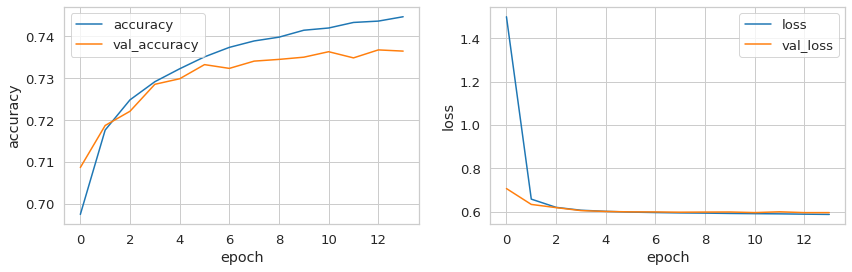

In [ ]:
plot_history(fit)

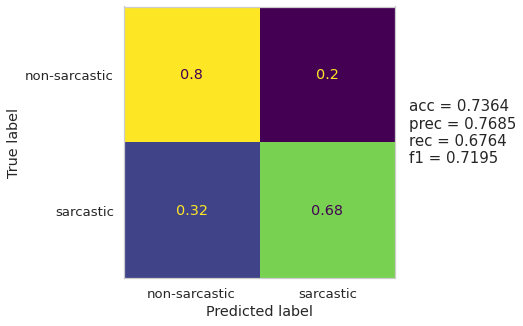

In [ ]:
evaluate(model, X_val_tok, y_val)

In [ ]:
show_errors(model, X_val, X_val_tok, y_val, n=5)

False negatives:
---------------------------
just skip PKA this week
I refuse to believe what you say and I for one welcome the many duplicate posts about over heating after the W10 upgrade.
At least 6 weeks.
Sorry
HAHAHAHAHAHA

False positives:
---------------------------
There's nothing casual about it
So no shame for Aldo losing to Conor then?
Honestly, once Pat eventually retires, he needs to take over MLG/CWL/ESL because this man knows what's right for the competitive Call of Duty community.
I have not, but i should definitely look into it!
that drop against oakland was killer he literally had no one in front of him if he had caught that he would have taken it the distance


In [ ]:
model.save(root+'cnn_bilstm_adam_regularized')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_bilstm_adam_regularized/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_bilstm_adam_regularized/assets


## twitter embeddings

In [ ]:
vec_len = 50
wordemb = WordEmbeddings()
embedding_matrix = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer, twitter=True)

for twitter vec_len = 50
coverage: 0.9931


In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen, mask_zero=True,
              weights=[embedding_matrix], trainable=True),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(3),
    Conv1D(32, 3, activation='relu', padding='same'),
    Bidirectional(LSTM(20, recurrent_dropout=0.5)),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 596s 97ms/step - loss: 0.5608 - accuracy: 0.7074 - val_loss: 0.5390 - val_accuracy: 0.7252
Epoch 2/50
6002/6002 [==============================] - 614s 102ms/step - loss: 0.5276 - accuracy: 0.7344 - val_loss: 0.5328 - val_accuracy: 0.7295
Epoch 3/50
6002/6002 [==============================] - 595s 99ms/step - loss: 0.5114 - accuracy: 0.7461 - val_loss: 0.5349 - val_accuracy: 0.7298
Epoch 4/50
6002/6002 [==============================] - 612s 102ms/step - loss: 0.4969 - accuracy: 0.7566 - val_loss: 0.5384 - val_accuracy: 0.7306
Epoch 5/50
6002/6002 [==============================] - 610s 102ms/step - loss: 0.4829 - accuracy: 0.7668 - val_loss: 0.5426 - val_accuracy: 0.7294


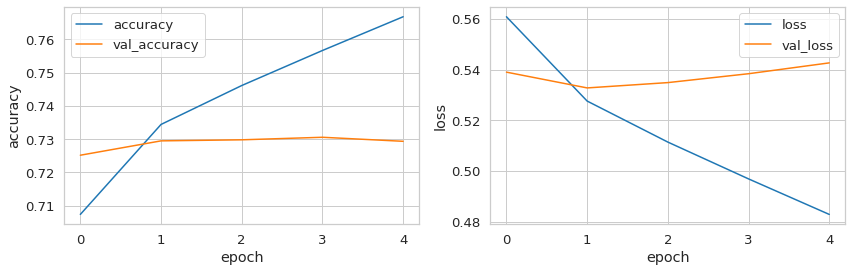

In [ ]:
plot_history(fit)

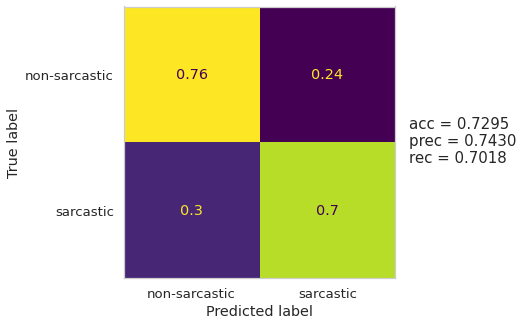

In [ ]:
evaluate(model, X_val_tok, y_val)

In [ ]:
show_errors(tokenizer, model, X_val, y_val, n=5)

False negatives:
---------------------------
i do not know about you ,  i did luge in my backyard all the time as a kid
raising a child to  costs about as much as med school ,  so they are pretty much the same . 
kwality
i believe your story  %  . 
you mean mobileme ? 

False positives:
---------------------------
are not hot and cold water pipes the same material ? 
draw childish pictures of penises on other people 's  personal property
challenger explosion . 
got to make the postseason first
they would just put the pictures up and we would all start jerking off as one nation under gawwwwd


In [ ]:
model.save(root+'cnn_bilstm_adam_twitter')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_bilstm_adam_twitter/assets


## freezing

In [ ]:
vec_len = 100
wordemb = WordEmbeddings()
embedding_matrix = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer)

coverage: 0.9832


In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

In [ ]:
embedding_layer = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                            mask_zero=True, weights=[embedding_matrix])
embedding_layer.trainable = False

In [ ]:
model = Sequential([
    embedding_layer,
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(3),
    Conv1D(32, 3, activation='relu', padding='same'),
    Bidirectional(LSTM(20, recurrent_dropout=0.5)),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 336s 54ms/step - loss: 0.5946 - accuracy: 0.6765 - val_loss: 0.5755 - val_accuracy: 0.6951
Epoch 2/50
6002/6002 [==============================] - 321s 54ms/step - loss: 0.5673 - accuracy: 0.7007 - val_loss: 0.5649 - val_accuracy: 0.7029
Epoch 3/50
6002/6002 [==============================] - 321s 53ms/step - loss: 0.5593 - accuracy: 0.7076 - val_loss: 0.5616 - val_accuracy: 0.7055
Epoch 4/50
6002/6002 [==============================] - 317s 53ms/step - loss: 0.5545 - accuracy: 0.7119 - val_loss: 0.5603 - val_accuracy: 0.7074
Epoch 5/50
6002/6002 [==============================] - 327s 54ms/step - loss: 0.5514 - accuracy: 0.7145 - val_loss: 0.5603 - val_accuracy: 0.7089
Epoch 6/50
6002/6002 [==============================] - 313s 52ms/step - loss: 0.5491 - accuracy: 0.7167 - val_loss: 0.5566 - val_accuracy: 0.7111
Epoch 7/50
6002/6002 [==============================] - 313s 52ms/step - loss: 0.5467 - accuracy: 0.7180 - val_loss: 0

In [ ]:
embedding_layer.trainable = True
adam = tf.keras.optimizers.Adam(1e-5)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=3)

Epoch 1/3
6002/6002 [==============================] - 325s 53ms/step - loss: 0.5397 - accuracy: 0.7238 - val_loss: 0.5533 - val_accuracy: 0.7135
Epoch 2/3
6002/6002 [==============================] - 309s 51ms/step - loss: 0.5369 - accuracy: 0.7259 - val_loss: 0.5521 - val_accuracy: 0.7147
Epoch 3/3
6002/6002 [==============================] - 321s 54ms/step - loss: 0.5351 - accuracy: 0.7274 - val_loss: 0.5513 - val_accuracy: 0.7153


In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=3, callbacks=[es])

Epoch 1/3
6002/6002 [==============================] - 337s 56ms/step - loss: 0.5337 - accuracy: 0.7285 - val_loss: 0.5505 - val_accuracy: 0.7158
Epoch 2/3
6002/6002 [==============================] - 338s 56ms/step - loss: 0.5322 - accuracy: 0.7296 - val_loss: 0.5498 - val_accuracy: 0.7165
Epoch 3/3
6002/6002 [==============================] - 335s 56ms/step - loss: 0.5310 - accuracy: 0.7305 - val_loss: 0.5492 - val_accuracy: 0.7170


In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, restore_best_weights=True)
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=30, callbacks=[es])

Epoch 1/30
6002/6002 [==============================] - 351s 59ms/step - loss: 0.5298 - accuracy: 0.7314 - val_loss: 0.5486 - val_accuracy: 0.7174
Epoch 2/30
6002/6002 [==============================] - 348s 58ms/step - loss: 0.5287 - accuracy: 0.7323 - val_loss: 0.5482 - val_accuracy: 0.7180
Epoch 3/30
6002/6002 [==============================] - 351s 58ms/step - loss: 0.5276 - accuracy: 0.7331 - val_loss: 0.5477 - val_accuracy: 0.7184


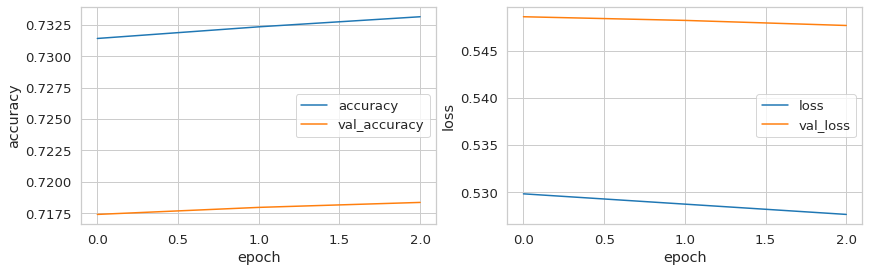

In [ ]:
plot_history(fit)

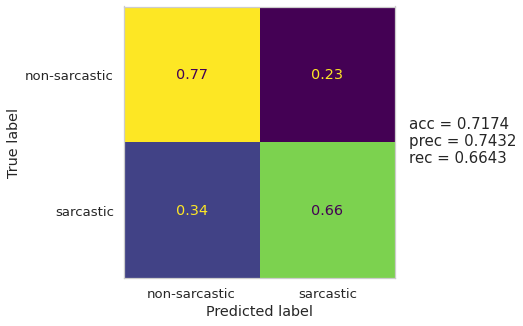

In [ ]:
evaluate(model, X_val_tok, y_val)

# CNN + LSTM + DNN (Fracking Sarcasm using Neural Network)

## normal
ran: 20.03.2022

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen, mask_zero=True,
              weights=[embedding_matrix], trainable=True),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal'),
    Conv1D(128, 3, activation='relu', kernel_initializer='he_normal'),
    LSTM(50, dropout=0.25, return_sequences=True),
    LSTM(50, dropout=0.25),
    Dense(50, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 133s 21ms/step - loss: 0.5628 - accuracy: 0.7063 - val_loss: 0.5378 - val_accuracy: 0.7268
Epoch 2/50
6002/6002 [==============================] - 128s 21ms/step - loss: 0.5260 - accuracy: 0.7368 - val_loss: 0.5279 - val_accuracy: 0.7340
Epoch 3/50
6002/6002 [==============================] - 128s 21ms/step - loss: 0.5073 - accuracy: 0.7501 - val_loss: 0.5256 - val_accuracy: 0.7365
Epoch 4/50
6002/6002 [==============================] - 126s 21ms/step - loss: 0.4892 - accuracy: 0.7629 - val_loss: 0.5331 - val_accuracy: 0.7349
Epoch 5/50
6002/6002 [==============================] - 127s 21ms/step - loss: 0.4711 - accuracy: 0.7756 - val_loss: 0.5323 - val_accuracy: 0.7342
Epoch 6/50
6002/6002 [==============================] - 128s 21ms/step - loss: 0.4526 - accuracy: 0.7879 - val_loss: 0.5489 - val_accuracy: 0.7306


In [21]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen, mask_zero=True, weights=[embedding_matrix],
              trainable=True, embeddings_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-5)),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv1D(128, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    LSTM(50, dropout=0.3, return_sequences=True),
    LSTM(50, dropout=0.3),
    Dense(50, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 137s 22ms/step - loss: 1.3471 - accuracy: 0.6979 - val_loss: 0.6820 - val_accuracy: 0.7159
Epoch 2/50
6002/6002 [==============================] - 132s 22ms/step - loss: 0.6480 - accuracy: 0.7183 - val_loss: 0.6263 - val_accuracy: 0.7242
Epoch 3/50
6002/6002 [==============================] - 131s 22ms/step - loss: 0.6169 - accuracy: 0.7246 - val_loss: 0.6113 - val_accuracy: 0.7260
Epoch 4/50
6002/6002 [==============================] - 131s 22ms/step - loss: 0.6069 - accuracy: 0.7293 - val_loss: 0.6044 - val_accuracy: 0.7295
Epoch 5/50
6002/6002 [==============================] - 131s 22ms/step - loss: 0.6021 - accuracy: 0.7325 - val_loss: 0.6018 - val_accuracy: 0.7325
Epoch 6/50
6002/6002 [==============================] - 131s 22ms/step - loss: 0.5986 - accuracy: 0.7359 - val_loss: 0.6007 - val_accuracy: 0.7331
Epoch 7/50
6002/6002 [==============================] - 131s 22ms/step - loss: 0.5967 - accuracy: 0.7373 - val_loss: 0

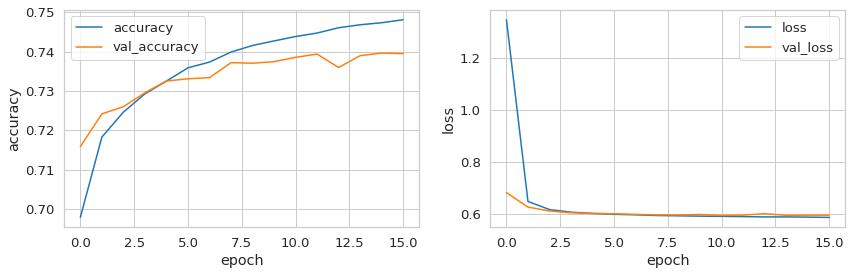

In [22]:
plot_history(fit)

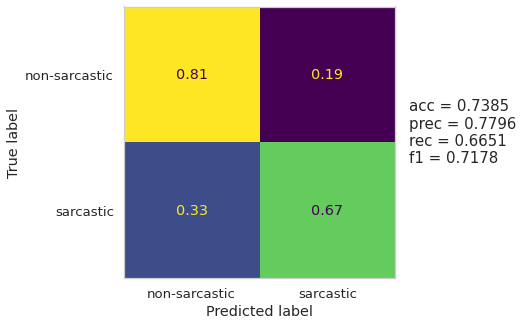

In [23]:
evaluate(model, X_val_tok, y_val)

In [24]:
show_errors(model, X_val, X_val_tok, y_val, n=5)

False negatives:
---------------------------
It's part of their fierce feminist message.
How can I get a job at Achievement Hunter?
77 percent of 2,245 = 1728.65 Enough people to ascertain whether the DCEU Superman is "unpopular" or not.
No way, I hate being stuck in tents with mostly naked, attractive, fit guys when its 2 degrees outside and cuddling is mandatory.
high school, though, that's acceptable.

False positives:
---------------------------
Don't worry royalty payment from braveheart will pay for it.
names develop naturally based on the deck's origins and the history of card games in general, you can argue thats why we should keep the name reno but trying to make all deck names "original" is just silly and pointless
Sky Sports don't do it with cricket and rugby, why would they do it with football?
Yes It was it is their fault for not doing it
As long as you're white and straight


In [25]:
model.save(root+'cnn_lstm_dnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_lstm_dnn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_lstm_dnn/assets


## freezing
ran: 20.03.2021

In [26]:
embedding_layer = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                            mask_zero=True, weights=[embedding_matrix])
embedding_layer.trainable = False

In [27]:
model = Sequential([
    embedding_layer,
    Conv1D(32, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    LSTM(50, dropout=0.3, return_sequences=True),
    LSTM(50, dropout=0.3),
    Dense(50, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 120s 19ms/step - loss: 0.5998 - accuracy: 0.6719 - val_loss: 0.5799 - val_accuracy: 0.6904
Epoch 2/50
6002/6002 [==============================] - 112s 19ms/step - loss: 0.5704 - accuracy: 0.6987 - val_loss: 0.5657 - val_accuracy: 0.7038
Epoch 3/50
6002/6002 [==============================] - 114s 19ms/step - loss: 0.5612 - accuracy: 0.7069 - val_loss: 0.5610 - val_accuracy: 0.7068
Epoch 4/50
6002/6002 [==============================] - 111s 19ms/step - loss: 0.5558 - accuracy: 0.7114 - val_loss: 0.5623 - val_accuracy: 0.7060
Epoch 5/50
6002/6002 [==============================] - 113s 19ms/step - loss: 0.5521 - accuracy: 0.7141 - val_loss: 0.5527 - val_accuracy: 0.7145
Epoch 6/50
6002/6002 [==============================] - 111s 18ms/step - loss: 0.5492 - accuracy: 0.7171 - val_loss: 0.5535 - val_accuracy: 0.7119
Epoch 7/50
6002/6002 [==============================] - 111s 18ms/step - loss: 0.5466 - accuracy: 0.7188 - val_loss: 0

In [28]:
embedding_layer.trainable = True
adam = tf.keras.optimizers.Adam(3e-4)

In [29]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit2 = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=30, callbacks=[es])

Epoch 1/30
6002/6002 [==============================] - 136s 21ms/step - loss: 0.5279 - accuracy: 0.7334 - val_loss: 0.5335 - val_accuracy: 0.7301
Epoch 2/30
6002/6002 [==============================] - 128s 21ms/step - loss: 0.5131 - accuracy: 0.7448 - val_loss: 0.5303 - val_accuracy: 0.7321
Epoch 3/30
6002/6002 [==============================] - 126s 21ms/step - loss: 0.5026 - accuracy: 0.7523 - val_loss: 0.5331 - val_accuracy: 0.7320
Epoch 4/30
6002/6002 [==============================] - 128s 21ms/step - loss: 0.4938 - accuracy: 0.7590 - val_loss: 0.5319 - val_accuracy: 0.7348
Epoch 5/30
6002/6002 [==============================] - 128s 21ms/step - loss: 0.4862 - accuracy: 0.7649 - val_loss: 0.5355 - val_accuracy: 0.7326


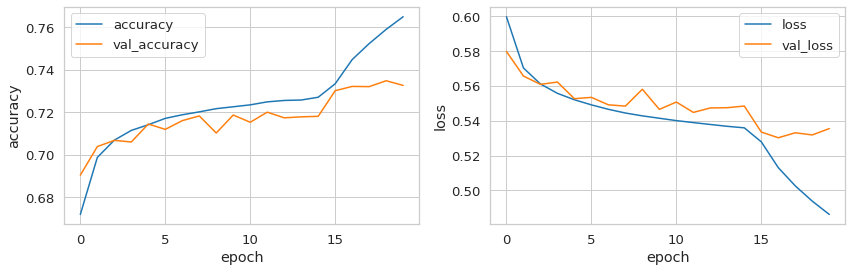

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))

for i, which in enumerate(['accuracy', 'loss']):
    ax = axes[i]
    ax.plot(fit.history[which]+fit2.history[which], label=which)
    ax.plot(fit.history['val_'+which]+fit2.history['val_'+which], label='val_'+which)
    ax.set_xlabel('epoch')
    ax.set_ylabel(which)
    ax.legend();

In [ ]:
# smaller learning rate, but embedding regularization is better anyway probably, so dk

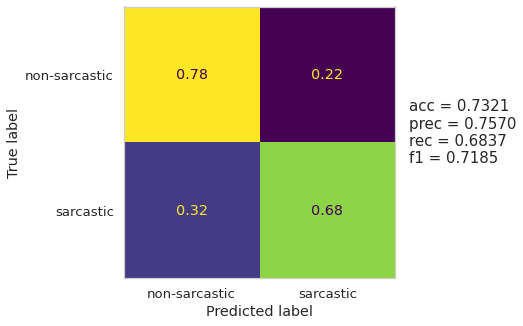

In [31]:
evaluate(model, X_val_tok, y_val)

In [32]:
show_errors(model, X_val, X_val_tok, y_val, n=5)

False negatives:
---------------------------
What better way to get known?
I thought it was from The Lion King.
Found the neckbeard.
Carr frequents Tumblr.
Wrong manufacturer

False positives:
---------------------------
84 Plus C Silver Edition owner here, why can't we get the good stuff?
Wow what a cheap alternative to tile?
Was the "hi" guy thinking that by sending "hi", he would get a paragraph response about how amazing he is?
Full gif it improves to 75%!
The disrespect is 100% worth it


In [33]:
model.save(root+'cnn_lstm_dnn_freeze_unfreeze')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_lstm_dnn_freeze_unfreeze/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_lstm_dnn_freeze_unfreeze/assets
